# Optimal Sampling sur un intervalle

*Author : Benjamin Pineau*

On applique ici la théorie de l'optimal sampling sur un intervalle $X = [a, b] \subset \mathbb{R}$. On se place dans l'espace $(X, \text{d}\rho)$ où $\rho$ est la mesure uniforme. 

L'espace de fonction pour approximer une fonction $u$ définie sur $X$ sera $V_m = \mathbb{P_{m-1}}$, muni de la base de Legendre orthonormée

In [1]:
# Importation des bibliotheques
import numpy as np
from scipy.special import legendre
from numpy.polynomial import Polynomial
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from numpy.linalg import cond
from scipy import stats
import pandas as pd
import time
from scipy.stats import norm
from scipy.stats import uniform
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from numpy.linalg import lstsq
import numpy.random as rnd

## Définition des fonctions 

Dans un premier temps on définit toutes les fonctions utiles à l'application de l'optimal sampling

In [2]:
#Définition d'une base de L2(X, dp)

def base_legendre(degree, a, b):

    # INPUT : la dimension de la base de L2([-1, 1], dp)
    # OUTPUT : une base de dimension d'entrée, avec des polynomes de Legendre (sous forme de liste)

    base = []
    for j in range(degree + 1):
        coeffs = [0 for i in range(j+1)]
        if j == 0:
            coeffs = [1]
        else:
            coeffs[-1] = 1
        P_j = Legendre(coeffs, domain = [a, b])
        phi_j = np.sqrt((2*j + 1)/2)*P_j
        base.append(phi_j.convert(domain = [a, b], kind=Legendre))

    return base

In [3]:
# Définition de la mesure pour l'échantillonage optimal

def density_phi1(x, rho, base, m):

    # INPUT : un vecteur de données x, une densité rho, une base (sous forme de liste de polynomes), la taille de la base 
    # OUTPUT : un vecteur qui suit la loi d'une certaine densité (cf rapport)

    phi1 = rho * sum( (1/m * (base[i](x))**2 ) for i in range(m))
    return phi1

In [4]:
# Sampling de n réalisation selon la mesure optimal par la méthode du rejet

def sequential_conditional_sampling_rejet(n, m, base, a, b):

    # INPUT : la taille de l'échantillon à creer, la taille de la base, une base sous forme de liste de polynome de Legendre
    # OUTPUT : n échantillons de la loi décrite dans le rapport générer par la méthode du rejet

    loi_uniform = stats.uniform(loc = a, scale = b - a)
    liste_coeff = [1/m for i in range(m)]
        
    #on génère n points par la méthode du rejet :
    t = np.linspace(a, b, 100)
    phi1 = density_phi1(t, loi_uniform.pdf(t), base, m)
    max_density = max(phi1)

    samples = []
    while len(samples) < n:
        t_candidate = np.random.uniform(a, b)
        u = np.random.uniform(0, 1)
        if 2*max_density*loi_uniform.pdf(t_candidate)*u < density_phi1(t_candidate, loi_uniform.pdf(t_candidate), base, m):
            samples.append(t_candidate)
    
    return np.array(samples)

In [5]:
# Sampling de n réalisation selon la mesure optimal par discrétisation

def sequential_conditional_sampling_discretisation(n, m, base, a, b):

    # INPUT : la taille de l'échantillon à creer, la taille de la base, une base sous forme de liste de polynome de Legendre
    # OUTPUT : n échantillons de la loi décrite dans le rapport générer par la méthode du rejet
    
    loi_uniform = stats.uniform(loc = a, scale = b - a)
    t = np.linspace(a, b, 1000)
    dt = (b - a)/1000
    densite_phi = density_phi1(t, loi_uniform.pdf(t), base, m)
    proba_discrete = densite_phi*dt
    proba_discrete = proba_discrete/(sum(proba_discrete))

    index_samples = rnd.choice(a = len(t), p = proba_discrete, size = n)
    samples = t[index_samples]
    
    return np.array(samples)

In [6]:
# Définition du produit scalaire discret

def produit_scalaire_n(u, v, w, x):

    # INPUT : 2 fonctions, une liste de poids, un vecteur de données
    # OUTPUT : le produit scalaire des 2 fonctions u et v évalués en x

    n = len(x)
    ps = 1/n* sum( (w[i] * u(x[i]) * v(x[i])) for i in range(n))
    return ps

In [7]:
# Définition des poids (pour le produit scalaire notamment)

def poids_ls_opti(m, base, x):
    
    # INPUT : la taille de la base, une base sous forme de liste de polynome de Legendre, un vecteur de données
    # OUTPUT : les poids associés à x selon la base donnée
    
    w = np.zeros(len(x))
    for i in range(len(x)):
        w[i] = m / (sum( (abs((base[j]*base[j])(x[i]))) for j in range(m)))
    return w

In [8]:
# Calcul de la matrice de Gram pour le produit scalaire discret

def matrice_gram(x, base):
        
    # INPUT : un vecteur de données, une base sous forme de liste de polynome de Legendre
    # OUTPUT : une matrice de Gram associée à la base évaluée en x
    
    m = len(base)
    G = np.zeros((m, m))
    w = poids_ls_opti(m, base, x)
    for i, phi_i in enumerate(base):
        for j, phi_j in enumerate(base):
            G[i, j] = produit_scalaire_n(base[i], base[j], w, x)
    return G

In [9]:
def conditionnement_gram(n_values, m_values, nb_iter, a, b):

    # INPUT : la taille de l'échantillon à générer, la taill de la base, le nombre d'itération à effectuer pour calculer la probabilité empirique de Cond(G) < 3
    # OUTPUT : la probabilité que Cond(G) < 3
    
    results = np.zeros((len(m_values), len(n_values)))
    for i, m in enumerate(m_values):
        base = base_legendre(m-1, a, b)  # Génère la base pour dimension m
        for j, n in enumerate(n_values):
            count_stable = 0
            for _ in range(nb_iter):
                x_samples = sequential_conditional_sampling_discretisation(n, m, base, a, b)
                G = matrice_gram(x_samples, base)
                cond_G = cond(G)
                if cond_G <= 3:
                    count_stable += 1
            results[i, j] = count_stable / nb_iter  # Probabilité empirique
    return results

In [10]:
# Test de propriétés entre le conditionnement de la matrice de Gram et sa comparaison à la matrice idendité

def proba_gram(n, m, nb_iter, a, b):
    
    # INPUT : la taille de l'échantillon à générer, la taill de la base, le nombre d'itération à effectuer pour calculer la probabilité empirique de Cond(G) < 3
    # OUTPUT : la probabilité que Cond(G) < 3
    
    base = base_legendre(m-1, a, b)
    count_stable = 0
    for _ in range(nb_iter):
        x_samples = sequential_conditional_sampling_discretisation(n, m, base, a, b)
        G = matrice_gram(x_samples, base)
        cond_G = cond(G)
        if cond_G <= 3:
            count_stable += 1
    result = count_stable / nb_iter  # Probabilité empirique
    return result

In [11]:
# Fonction que l'on cherche à approximer

def recherche_fonction(x):

    # INPUT : un vecteur de données x
    # OUTPUT : la fonction que l'on cherche à estimer évaluée en x
    
    u = np.zeros(len(x))
    for i in range(len(x)):
        #u[i] = x[i]**2
        u[i] = x[i]**2 - 1/10*x[i]**3 + 3*x[i]
        #u[i] = np.sin(x[i]**2) + np.log(np.abs(x[i]) + 1)/(x[i]**2 + 1) - np.exp(-np.cos(x[i]))

    return u

In [12]:
# Calcul du vecteur d tel que Gv = d 
# G = matrice de Gram
# v = vecteur des évaluations d'une fonction u (par exemple celle que l'on cherche à approcher)

def calcul_data_vector(x, base, w, y):

    # INPUT : un vecteur de données, la base sous forme de liste de polynome de Legendre, une liste de poids, un vecteur d'observation
    # OUTPUT : data vector (cf rapport)
    
    n = len(x)
    m = len(base)
    data_vector = np.zeros(m)
    for j in range(m):
        data_vector[j] = 1/n*sum((w[i]*y[i]*base[j](x[i])) for i in range(n))
    
    return data_vector

## Application globale de la théorie de l'optimal sampling

A présent on peut tester l'optimal sampling en faisant varier divers paramètre comme le nombre d'échantillon ou la taille de la base. On comparera l'optimal sampling et la méthode des moindres carrés classique. 

Enfin, on pourra faire varier la fonction que l'on cherche à approximer

erreur weighted least-squares : 5.80691304532528e-13
erreur least-squares : 4.738144446424663e-12


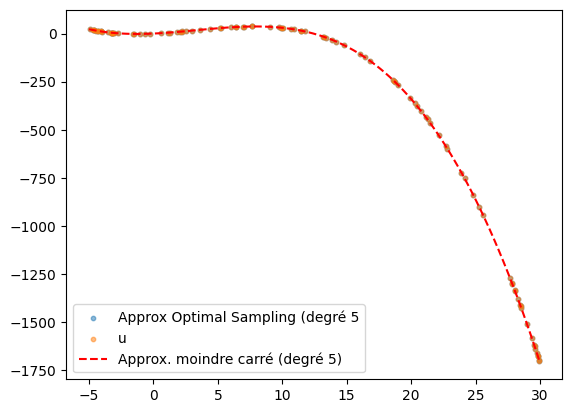

In [20]:
# Application globale de la théorie de l'optimal sampling

# paramètres
a, b = -5, 30   # intervale [a, b] d'étude
n_vect = 100    # nombre de point à sampler
m_base = 5     # taille de la base V_m

# création de la base et calcul des points optimaux résultant
base = base_legendre(m_base - 1, a, b)
x_samples = sequential_conditional_sampling_discretisation(n_vect, m_base, base, a, b)
poids = poids_ls_opti(m_base, base, x_samples)
y = recherche_fonction(x_samples)

# Calcul de la matrice de Gram et de d = Gy
G = matrice_gram(x_samples, base)
d = calcul_data_vector(x_samples, base, poids, y)

# v est le vecteur des coefficients du polynome qui permettra d'approcher u 
# On résoud alors v = G-1.d 
v = np.dot(np.linalg.inv(G), d)
v_norm = np.array([v_k*np.sqrt((2*k + 1) / 2) for k, v_k in enumerate(v)])
v_Legendre = Legendre(v_norm, domain = [a, b])

# pour tester l'approximation obtenue, on sample de nouveau des points
x_test = sequential_conditional_sampling_discretisation(n_vect, m_base, base, a, b)
y1 = recherche_fonction(x_test)

# on compare la solution avec une technique de moindre carré classique
x_lstsq = np.linspace(a, b, n_vect)
y2 = recherche_fonction(x_lstsq)
X_LSTSQ = np.vander(x_lstsq, m_base + 1)
coeffs_lstsq, _, _, _ = lstsq(X_LSTSQ, y2, rcond=None)
y_lstsq = np.polyval(coeffs_lstsq, x_lstsq)



print('erreur weighted least-squares :', np.sqrt(1/n_vect* sum( (poids[i] * ( v_Legendre(x_test)[i] - y1[i]) * ( v_Legendre(x_test)[i] - y1[i] ) ) for i in range(n_vect))))
print('erreur least-squares :', np.sqrt( (x_lstsq[1] - x_lstsq[0]) * sum( (( y_lstsq[i] - y2[i]) * ( y_lstsq[i] - y2[i] ) ) for i in range(n_vect))))

plt.scatter(x_test, v_Legendre(x_test), label = f'Approx Optimal Sampling (degré {m_base}', s = 10, alpha = 0.5)
plt.scatter(x_test, y1, label = 'u', s = 10, alpha = 0.5)
plt.plot(x_lstsq, y_lstsq, label=f"Approx. moindre carré (degré {m_base})", linestyle="dashed", color = 'red')
plt.legend()
plt.show()

## Visualisation de certaines propriétés

On peut par exemple observer la propriété 
$$
m \leq \kappa \frac{n}{ln(n)}, \; \text{avec} \; \kappa = \frac{1 - ln(2)}{2 + 2r} \Longrightarrow \mathbf{P}(\text{cond}(\mathbf{G}) \leq 3) \geq 1 - 2n^{-r} \; \text{pour} \; r > 0
$$

In [14]:
# on calcule en amont la probabilité que le conditionnement de la matrice de gram soit inférieur à 3 avec la fonction conditionnement_gram définie plus haut
# on fait ce calcul pour divers valeur de n = nombre d'échantillon et m = taille de la base V_m

file_path= "proba_cond_gram.csv"
proba = pd.read_csv(file_path,
                          #delim_whitespace = True, 
                          sep=",")
                          #header = True)
proba = np.array(proba, dtype=float)

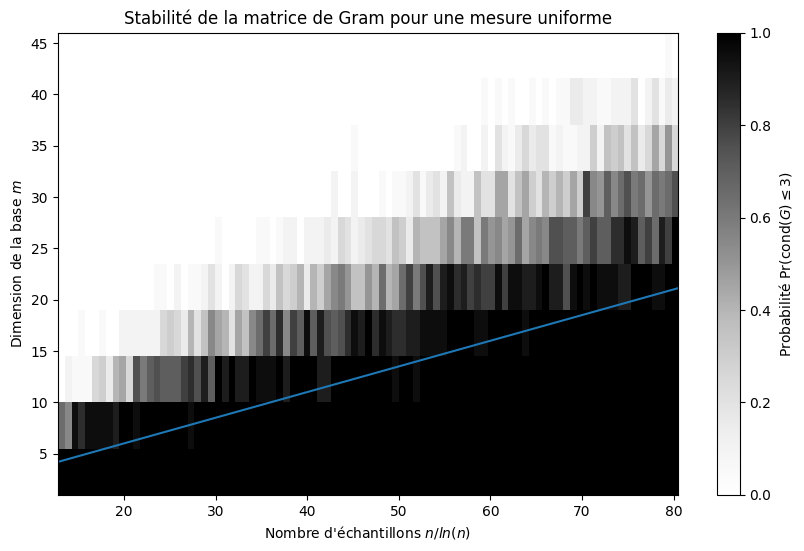

In [15]:
# visualisation, en affichant n/4ln(n) 

m_values = range(1, 50, 5)
n_values = range(50, 501, 5)
n_transformed = np.array([n / np.log(n) for n in n_values])


plt.figure(figsize=(10, 6))
plt.imshow(proba, aspect='auto', origin='lower', 
           extent=[min(n_transformed), max(n_transformed), min(m_values), max(m_values)],
           cmap='Greys')
plt.plot(n_transformed, n_transformed/4 + 1)
plt.colorbar(label='Probabilité $\Pr(\mathrm{cond}(G) \leq 3)$')
plt.xlabel('Nombre d\'échantillons $n/ln(n)$')
plt.ylabel('Dimension de la base $m$')
plt.title('Stabilité de la matrice de Gram pour une mesure uniforme')
plt.show()

In [16]:
# Créer un masque pour sélectionner uniquement les indices valides
mask = np.array([[m <= n / (4*np.log(n)) for n in n_values] for m in m_values])

# Appliquer le masque à results
filtered_results = np.where(mask, proba, np.nan)  # Remplace les valeurs non valides par NaN

valid_values = proba[mask]  # Contient uniquement les valeurs où m <= n / ln(n)

print(valid_values)


[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.95
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   0.9  1.   1.   1.   1.   1.   1.   1.   1.   1.   0.95 1.   1.
 0.95 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1